# Identifikasi 2 Suara

## Langkah Pertama: Membuat Dataset Awal

Langkah pertama yang dilakukan adalah menjalankan file generate dataset.py untuk membentuk dataset awal yang akan digunakan pada tahap pelatihan model. Pada proses ini, program akan memeriksa apakah file data/voice_dataset.csv sudah tersedia. Jika file tersebut belum ada, fungsi create_dataset() dari modul feature_extraction.py akan dijalankan untuk membuat dataset baru dengan mengekstraksi fitur dari seluruh file suara berformat .wav yang berada di dalam folder data/. Proses ekstraksi fitur dilakukan dengan memanfaatkan pustaka Librosa, yang menghasilkan berbagai fitur seperti MFCC, chroma, spectral contrast, zero crossing rate, RMS, spectral centroid, bandwidth, dan rolloff. Setiap file suara dikaitkan dengan label pengguna (user1 atau user2) dan kondisi (buka atau tutup). Setelah semua data terkumpul, hasil ekstraksi disimpan dalam bentuk tabel DataFrame dan kemudian diekspor ke dalam file CSV. Tahap ini bertujuan untuk memastikan data suara telah diubah menjadi bentuk numerik yang dapat digunakan pada proses pelatihan model klasifikasi selanjutnya.





### generate_dataset.py

In [ ]:
import os
import pandas as pd
from utils.feature_extraction import create_dataset

def main():
    output_csv = "data/voice_dataset.csv"

    if not os.path.exists(output_csv):
        print("[INFO] Dataset belum ditemukan, sedang dibuat...")
        df = create_dataset(output_csv=output_csv)
    else:
        df = pd.read_csv(output_csv)
        print(f"[INFO] Dataset sudah ada: {output_csv} ({len(df)} sampel)")

    print("[INFO] Contoh 5 baris dataset:")
    print(df.head())

    print("[INFO] Kolom dataset:")
    print(df.columns.tolist())

    # Pastikan kolom numerik untuk fitur
    feature_cols = [col for col in df.columns if col.startswith("mfcc")]
    df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

    print(f"[INFO] Dataset siap digunakan dengan {len(feature_cols)} fitur.")

if __name__ == "__main__":
    main()

Kode itu berfungsi untuk membangun dan menyiapkan dataset awal yang akan digunakan dalam proses pelatihan model pengenalan suara. Kode ini secara otomatis mengumpulkan data dari file audio berformat .wav yang tersimpan dalam struktur folder tertentu (misalnya data/user1/buka atau data/user2/tutup), kemudian memanggil fungsi create_dataset() dari file feature_extraction.py untuk mengekstraksi fitur akustik dari setiap file suara. Fitur-fitur yang diambil mencakup parameter penting seperti MFCC, chroma, spectral contrast, zero crossing rate, RMS, dan fitur spektral lainnya yang merepresentasikan karakteristik unik dari setiap rekaman suara.

Hasil ekstraksi tersebut dikonversi menjadi bentuk numerik dan digabungkan dalam sebuah tabel (DataFrame) yang berisi kolom fitur serta label seperti user dan status, kemudian disimpan ke dalam file data/voice_dataset.csv. Dataset ini menjadi dasar bagi tahap pelatihan dua model pembeda, yaitu model untuk mengenali identitas pengguna dan model untuk menentukan status “buka” atau “tutup”. Dengan demikian, kegunaan utama kode ini adalah untuk mengotomatiskan proses pembentukan dataset siap pakai yang diperlukan sebelum model kecerdasan buatan dapat dilatih dan diimplementasikan dalam aplikasi pengenalan suara.

### feature_dataset.py

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa

def extract_features(file_path):
    """Ekstraksi fitur MFCC + fitur tambahan dari file WAV"""
    try:
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.util.normalize(y)

        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        rms = np.mean(librosa.feature.rms(y=y))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

        features = np.hstack([
            mfcc,
            chroma,
            spec_contrast,
            [zcr, rms, centroid, bandwidth, rolloff]
        ])

        features = np.nan_to_num(features)
        return {f"mfcc{i}": float(v) for i, v in enumerate(features)}

    except Exception as e:
        print(f"[ERROR] Gagal memproses {file_path}: {e}")
        return None

def create_dataset(data_dir="data", output_csv="data/voice_dataset.csv"):
    rows = []
    for user in os.listdir(data_dir):
        user_path = os.path.join(data_dir, user)
        if not os.path.isdir(user_path):
            continue

        for status in ["buka", "tutup"]:
            status_path = os.path.join(user_path, status)
            if not os.path.exists(status_path):
                continue

            for file in os.listdir(status_path):
                if file.endswith(".wav"):
                    path = os.path.join(status_path, file)
                    feats = extract_features(path)
                    if feats:
                        feats["user"] = user
                        feats["status"] = status
                        feats["filename"] = file
                        rows.append(feats)
                    else:
                        print(f"[SKIP] {path} tidak bisa diproses.")

    df = pd.DataFrame(rows)

    # Konversi user & status ke numerik
    df["user"] = df["user"].replace({"user1": 0, "user2": 1})
    df["status"] = df["status"].replace({"buka": 0, "tutup": 1})

    # Pastikan semua fitur numerik
    for col in df.columns:
        if col not in ["user", "status", "filename"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Hapus baris yang ada NaN
    df = df.dropna().reset_index(drop=True)

    # Simpan CSV
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"[INFO] Dataset berhasil dibuat: {output_csv} ({len(df)} sampel)")
    print(f"[DEBUG] Nilai unik user: {df['user'].unique()}")
    print(f"[DEBUG] Nilai unik status: {df['status'].unique()}")
    return df

if __name__ == "__main__":
    create_dataset()

Kegunaan kode ini adalah untuk mengubah file suara mentah (.wav) menjadi kumpulan data numerik (feature dataset) yang dapat digunakan oleh model machine learning. File ini menjadi pondasi utama dalam keseluruhan sistem, karena seluruh proses pelatihan dan prediksi model bergantung pada fitur-fitur yang dihasilkan dari kode ini.

Secara garis besar, feature_extraction.py memiliki dua fungsi utama, yaitu extract_features() dan create_dataset(), yang masing-masing memiliki peran penting:

1. Fungsi extract_features(file_path)
Fungsi ini digunakan untuk mengekstraksi fitur akustik dari satu file suara .wav.
Di dalamnya, pustaka Librosa digunakan untuk menghitung berbagai parameter suara seperti:

- MFCC (Mel-Frequency Cepstral Coefficients) → menggambarkan karakteristik utama suara manusia.

- Chroma → menunjukkan distribusi energi berdasarkan nada musik.

- Spectral contrast → mengukur kontras antara puncak dan lembah frekuensi.

- Zero crossing rate, RMS, Spectral centroid, Bandwidth, dan Rolloff → menggambarkan energi, frekuensi, dan dinamika suara.
Semua fitur ini dikonversi menjadi angka dan digabungkan ke dalam satu vektor numerik yang mewakili satu file suara.

2. Fungsi create_dataset(data_dir, output_csv)
Fungsi ini digunakan untuk mengumpulkan hasil ekstraksi dari banyak file suara sekaligus.
Program akan menelusuri setiap folder pengguna (misalnya user1 dan user2) dan status (buka atau tutup), lalu memanggil extract_features() untuk setiap file suara di dalamnya.
Semua hasil ekstraksi fitur kemudian digabungkan menjadi satu tabel (DataFrame) yang berisi kolom fitur serta label user, status, dan filename.
Hasil akhir dataset disimpan ke dalam file data/voice_dataset.csv, yang nantinya digunakan untuk melatih model.

## Langkah Kedua: Melatih Model Pengenalan Suara (Training Model Machine Learning)


Langkah kedua setelah menjalankan generate dataset.py adalah melatih model machine learning menggunakan dataset yang telah dibuat. Proses ini dilakukan dengan menjalankan dua file pelatihan, yaitu train user.py dan train status.py.

Pada tahap ini, dataset voice_dataset.csv yang berisi hasil ekstraksi fitur audio akan dibaca dan digunakan untuk membangun dua model klasifikasi yang berbeda. File train user.py digunakan untuk melatih model yang mampu mengenali identitas pengguna (misalnya user1 atau user2), sedangkan file train status.py digunakan untuk melatih model yang dapat membedakan kondisi suara (buka atau tutup).

Kedua file pelatihan ini menggunakan algoritma Random Forest yang digabungkan dengan StandardScaler melalui pipeline. Model mempelajari pola numerik dari fitur-fitur seperti MFCC, chroma, dan spectral contrast untuk memprediksi label yang sesuai. Setelah proses pelatihan selesai, model dan informasi urutan fitur disimpan dalam folder models/ sebagai file .pkl (user_model.pkl, status_model.pkl, dan feature_cols.pkl).

### train_user.py

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# === Load dataset ===
df = pd.read_csv("data/voice_dataset.csv")

# === Fitur 36 kolom ===
feature_cols = [col for col in df.columns if col.startswith("mfcc")]
X = df[feature_cols].to_numpy()
y = df["user"].to_numpy()  # 0=user1, 1=user2

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Pipeline RandomForest + StandardScaler ===
model_user = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# === Training ===
model_user.fit(X_train, y_train)

# === Simpan model dan feature order ===
os.makedirs("models", exist_ok=True)
joblib.dump(model_user, "models/user_model.pkl")
joblib.dump(feature_cols, "models/feature_cols.pkl")
print("[INFO] Model user berhasil disimpan.")

Kode ini digunakan untuk melatih model pengenalan identitas pengguna. Program membaca dataset dari file data/voice_dataset.csv, kemudian mengambil kolom-kolom fitur numerik hasil ekstraksi seperti MFCC, chroma, dan fitur spektral lainnya. Kolom label yang digunakan adalah user, yang berisi nilai 0 atau 1 sebagai representasi dari user1 dan user2.

Data dibagi menjadi dua bagian, yaitu data latih (training set) dan data uji (testing set) menggunakan fungsi train_test_split. Selanjutnya, data dimasukkan ke dalam pipeline yang terdiri dari dua tahap, yaitu StandardScaler untuk menormalkan nilai fitur agar berada pada skala yang sama, dan RandomForestClassifier untuk membangun model klasifikasi berbasis pohon keputusan. Setelah proses pelatihan selesai, model yang telah terbentuk disimpan ke dalam folder models/ dengan nama user_model.pkl, sedangkan daftar urutan kolom fitur disimpan dalam feature_cols.pkl.

Tujuan utama file ini adalah untuk menghasilkan model yang dapat mengenali pengguna berdasarkan karakteristik suara.

### train_status.py

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# === Load dataset ===
df = pd.read_csv("data/voice_dataset.csv")

# === Fitur 36 kolom ===
feature_cols = [col for col in df.columns if col.startswith("mfcc")]
X = df[feature_cols].to_numpy()
y = df["status"].to_numpy()  # 0=buka, 1=tutup

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Pipeline RandomForest + StandardScaler ===
model_status = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# === Training ===
model_status.fit(X_train, y_train)

# === Simpan model dan feature order ===
os.makedirs("models", exist_ok=True)
joblib.dump(model_status, "models/status_model.pkl")
joblib.dump(feature_cols, "models/feature_cols.pkl")
print("[INFO] Model status berhasil disimpan.")

Kode ini digunakan untuk melatih model pengenalan status suara, yaitu membedakan apakah suara tersebut tergolong “buka” atau “tutup”. Prosesnya serupa dengan train user.py, tetapi label target yang digunakan adalah kolom status.

Model ini juga menggunakan pipeline yang terdiri dari StandardScaler dan RandomForestClassifier, di mana data dibagi menjadi data latih dan data uji agar model dapat mengevaluasi kinerjanya dengan baik. Setelah pelatihan selesai, model disimpan ke dalam folder models/ dengan nama status_model.pkl, sementara urutan fitur juga disimpan pada feature_cols.pkl agar tetap konsisten saat proses prediksi.

Fungsi utama file ini adalah untuk menghasilkan model yang mendeteksi kondisi suara berdasarkan ciri akustik, apakah suara yang terekam merupakan perintah “buka” atau “tutup”.

## Langkah ketiga Menjalankan Aplikasi Pengenalan Suara (Implementasi Model di Streamlit).

Pada tahap ini, sistem yang sudah dilatih diintegrasikan ke dalam aplikasi berbasis web menggunakan Streamlit melalui file app.py. Tujuannya adalah agar pengguna dapat berinteraksi langsung dengan sistem pengenalan suara secara praktis dan real-time.

Ketika aplikasi dijalankan, dua model hasil pelatihan sebelumnya — user_model.pkl (untuk mengenali pengguna) dan status_model.pkl (untuk mengenali status suara “buka” atau “tutup”) — akan dimuat ke dalam program. Pengguna dapat memilih dua cara untuk memberikan input, yaitu dengan merekam suara langsung melalui mikrofon atau mengunggah file suara .wav.

Setelah itu, sistem akan menjalankan proses ekstraksi fitur menggunakan fungsi extract_features() dari file feature_extraction.py, lalu hasilnya dikirim ke kedua model untuk dilakukan prediksi identitas pengguna dan status suara. Aplikasi juga menggunakan pustaka SpeechRecognition untuk mengenali kata yang diucapkan, seperti “buka” atau “tutup”, sebagai tambahan verifikasi hasil prediksi.

### app.py

In [ ]:
import streamlit as st
import numpy as np
import joblib
import tempfile
import pandas as pd
from utils.feature_extraction import extract_features
from st_audiorec import st_audiorec

# ===== CONFIG =====
st.set_page_config(page_title="Voice Identification", page_icon="🎧", layout="centered")
st.title("🎙️ Voice Identification System")
st.write("""
Sistem ini melakukan identifikasi suara **buka/tutup** dari dua pengguna yang diizinkan:
**user1** dan **user2**.
Silakan rekam atau unggah file suara .wav.
""")

# ===== LOAD MODEL =====
try:
    model_user = joblib.load("models/user_model.pkl")
    model_status = joblib.load("models/status_model.pkl")
    feature_cols = joblib.load("models/feature_cols.pkl")
except Exception as e:
    st.error(f"Gagal memuat model: {e}")
    st.stop()

# ===== PILIH INPUT =====
input_option = st.radio("Pilih metode input:", ["🎤 Rekam suara", "📁 Upload file .wav"])

# ===== PROSES AUDIO =====
def process_audio(audio_path):
    import librosa
    import speech_recognition as sr

    features = extract_features(audio_path)
    if not features:
        st.error("Gagal mengekstraksi fitur dari suara.")
        return

    # ===== DETEKSI SILENCE =====
    y, sr_audio = librosa.load(audio_path, sr=None)
    rms = np.mean(librosa.feature.rms(y=y))
    duration = len(y)/sr_audio
    if duration < 0.1 or rms < 1e-4:
        st.error("Tidak ada suara yang terdeteksi. Silakan rekam ulang.")
        return

    feature_df = pd.DataFrame([features])
    # Pastikan urutan kolom sama seperti training
    X = feature_df[feature_cols].to_numpy().reshape(1, -1)
    st.write(f"Jumlah fitur yang dikirim ke model: {X.shape[1]}")

    # ===== PREDIKSI USER & STATUS =====
    user_pred_proba = model_user.predict_proba(X)
    status_pred_proba = model_status.predict_proba(X)
    user_pred = np.argmax(user_pred_proba)
    status_pred = np.argmax(status_pred_proba)
    user_confidence = np.max(user_pred_proba)
    status_confidence = np.max(status_pred_proba)

    # Mapping ke label
    user_label = f"user{user_pred + 1}"
    status_label = "buka" if status_pred == 0 else "tutup"

    # ===== SPEECH TO TEXT =====
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data, language="id-ID")
            st.subheader("📝 Teks yang terdeteksi")
            st.write(text)

            # Koreksi prediksi status berdasarkan kata
            text_lower = text.lower()
            if "buka" in text_lower:
                status_label = "buka"
            elif "tutup" in text_lower:
                status_label = "tutup"
    except Exception as e:
        st.warning(f"Teks tidak dapat dikenali: {e}")

    # ===== Hasil =====
    st.subheader("📊 Hasil Prediksi")
    st.success(f"**Prediksi:** {user_label} — {status_label}")
    st.info(f"User: {user_label} | Status: {status_label}")

    if status_label == "buka":
        st.write(f"🔊 Suara mirip **{user_label} saat membuka** sesuatu.")
    else:
        st.write(f"🔊 Suara mirip **{user_label} saat menutup** sesuatu.")

    # ===== Lihat fitur =====
    with st.expander("📈 Lihat fitur yang diekstraksi"):
        st.dataframe(feature_df.T, use_container_width=True)

# ===== INPUT REKAM =====
if input_option == "🎤 Rekam suara":
    st.write("Klik tombol di bawah untuk merekam suara Anda:")
    audio_bytes = st_audiorec()
    if audio_bytes is not None:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmpfile:
            tmpfile.write(audio_bytes)
            audio_path = tmpfile.name
        st.audio(audio_path, format="audio/wav")
        process_audio(audio_path)

# ===== INPUT UPLOAD =====
elif input_option == "📁 Upload file .wav":
    uploaded_file = st.file_uploader("Upload file suara (.wav):", type=["wav"])
    if uploaded_file is not None:
        st.audio(uploaded_file, format="audio/wav")
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmpfile:
            tmpfile.write(uploaded_file.read())
            audio_path = tmpfile.name
        process_audio(audio_path)

Fungsi kode app.py adalah untuk mengimplementasikan dan menjalankan sistem pengenalan suara melalui aplikasi berbasis web menggunakan Streamlit.


1. Menampilkan antarmuka aplikasi (UI):
Kode ini membuat tampilan interaktif menggunakan Streamlit, sehingga pengguna dapat dengan mudah berinteraksi dengan sistem tanpa harus menjalankan perintah melalui terminal.

2. Memuat model yang telah dilatih:
Program memanggil dua model hasil pelatihan sebelumnya, yaitu

- user_model.pkl, untuk mengenali siapa pengguna (user1 atau user2), dan

- status_model.pkl, untuk mengenali status suara (buka atau tutup).
Selain itu, file feature_cols.pkl juga dimuat untuk memastikan urutan fitur yang digunakan sama dengan saat pelatihan.

3. Menerima input suara:
Aplikasi menyediakan dua opsi input:

- Merekam suara secara langsung menggunakan mikrofon (st_audiorec()), atau

- Mengunggah file suara .wav.

4. Mengekstraksi fitur dari suara yang diberikan:
Setelah suara direkam atau diunggah, program memanggil fungsi extract_features() dari file feature_extraction.py untuk mengubah sinyal suara menjadi data numerik (fitur).

5. Melakukan prediksi:
Data fitur yang dihasilkan dikirim ke model machine learning untuk memprediksi:

- Siapa pengguna yang berbicara, dan

- Apakah suara tersebut menunjukkan perintah “buka” atau “tutup.”

6. Menampilkan hasil analisis:
Aplikasi menampilkan hasil prediksi secara real-time, termasuk label pengguna, status suara, serta tingkat kepercayaan model terhadap prediksi tersebut.

7. Menjalankan pengenalan kata (Speech-to-Text):
Dengan menggunakan pustaka SpeechRecognition, aplikasi juga dapat mengenali teks dari suara, membantu mengonfirmasi apakah pengguna mengucapkan kata “buka” atau “tutup.”


Fungsi utama kode app.py adalah menggabungkan model yang sudah dilatih, proses ekstraksi fitur, dan antarmuka pengguna menjadi satu sistem pengenalan suara interaktif. Kode ini menjadikan sistem dapat digunakan langsung oleh pengguna untuk melakukan identifikasi suara secara mudah dan praktis melalui web.

### Langkah Keempat: Pengujian dan Evaluasi Sistem Pengenalan Suara


Untuk menilai seberapa baik sistem mengenali suara pengguna dan membedakan status “buka” atau “tutup.”

Kegiatan yang dilakukan:

1. Melakukan uji coba suara baru.
Mencoba merekam atau mengunggah beberapa file suara dari pengguna yang sama dan berbeda (misalnya user1 dan user2) untuk melihat apakah sistem dapat mengenali dengan benar.

2. Menguji kondisi suara berbeda.
Uji sistem dengan suara “buka” dan “tutup” dalam berbagai intonasi, volume, atau kecepatan bicara untuk melihat konsistensi hasil prediksi.

3. Menganalisis hasil prediksi.
Bandingkan hasil yang muncul di aplikasi Streamlit dengan kondisi sebenarnya. Jika prediksi sering salah, kemungkinan dataset atau model perlu diperbaiki.

4. Melihat fitur hasil ekstraksi.
Gunakan fitur “📈 Lihat fitur yang diekstraksi” di aplikasi untuk memastikan proses ekstraksi berjalan normal dan nilai fitur terbaca dengan benar.

5. Mencatat tingkat akurasi model.
Jika ingin lebih formal, kamu bisa menambahkan pengujian akurasi menggunakan data uji (X_test, y_test) dari proses pelatihan model sebelumnya.

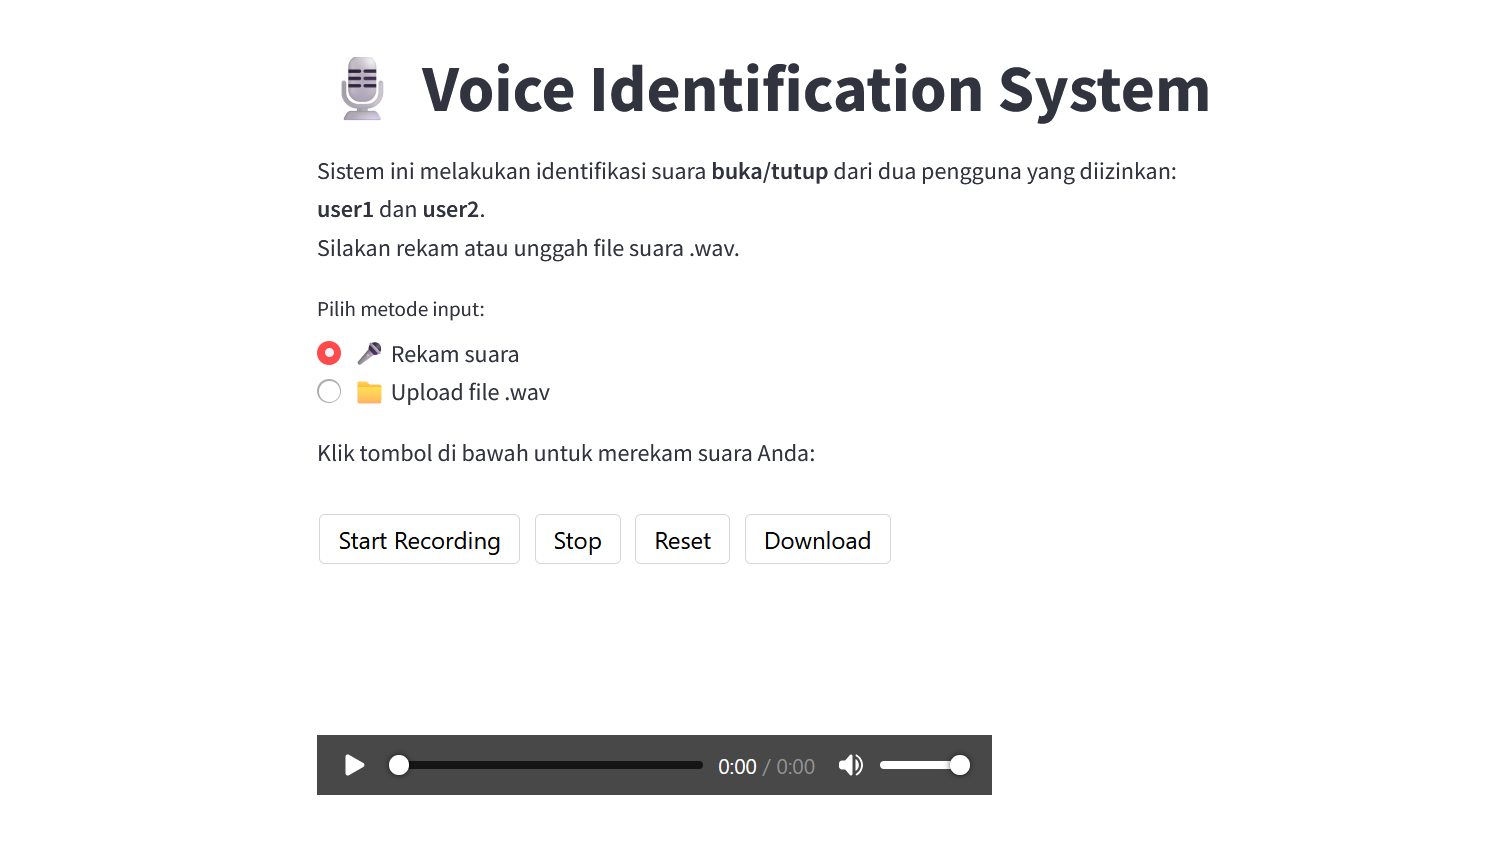

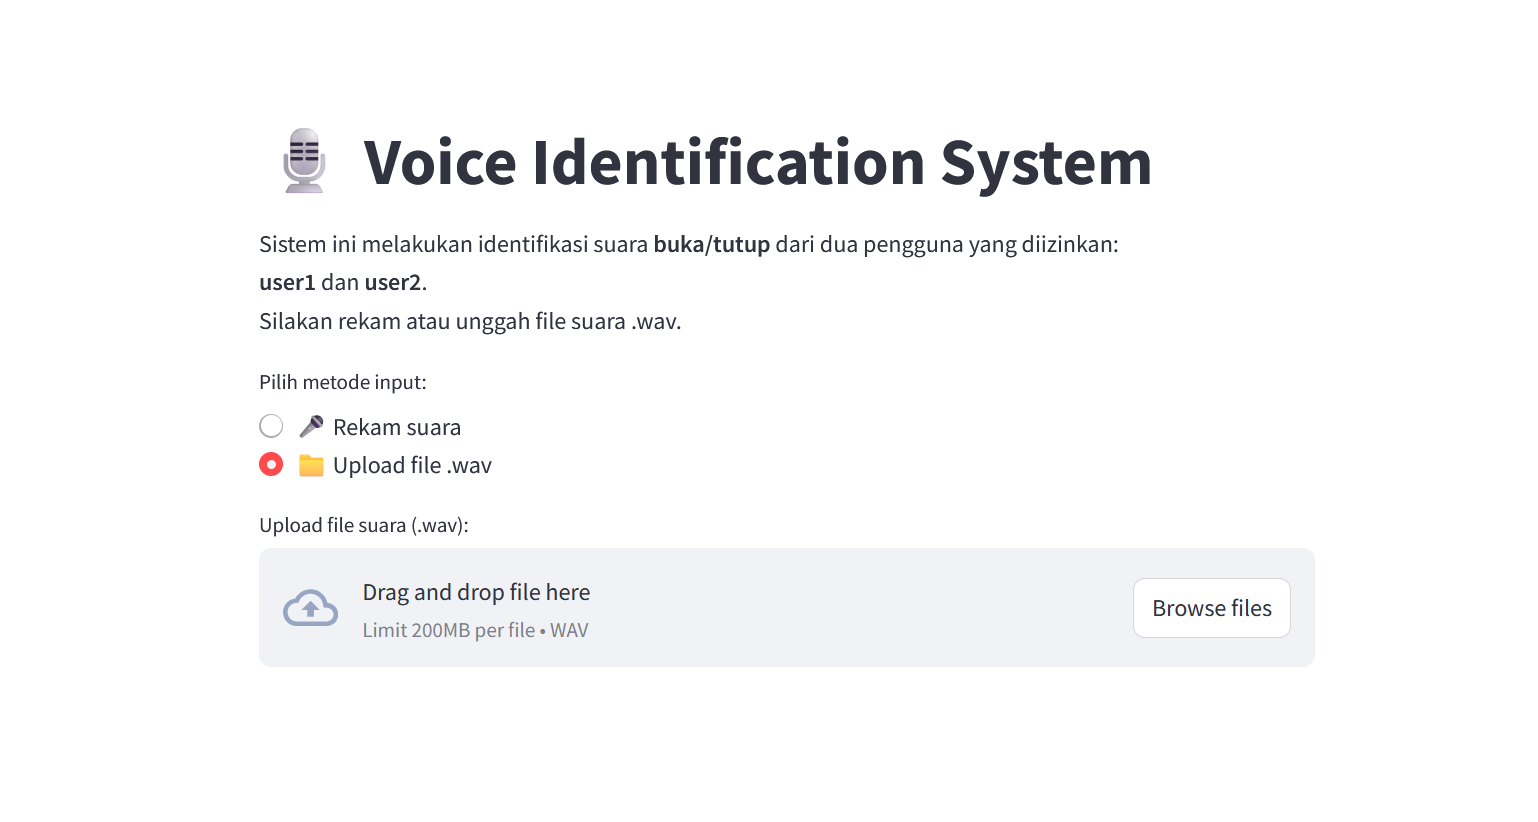

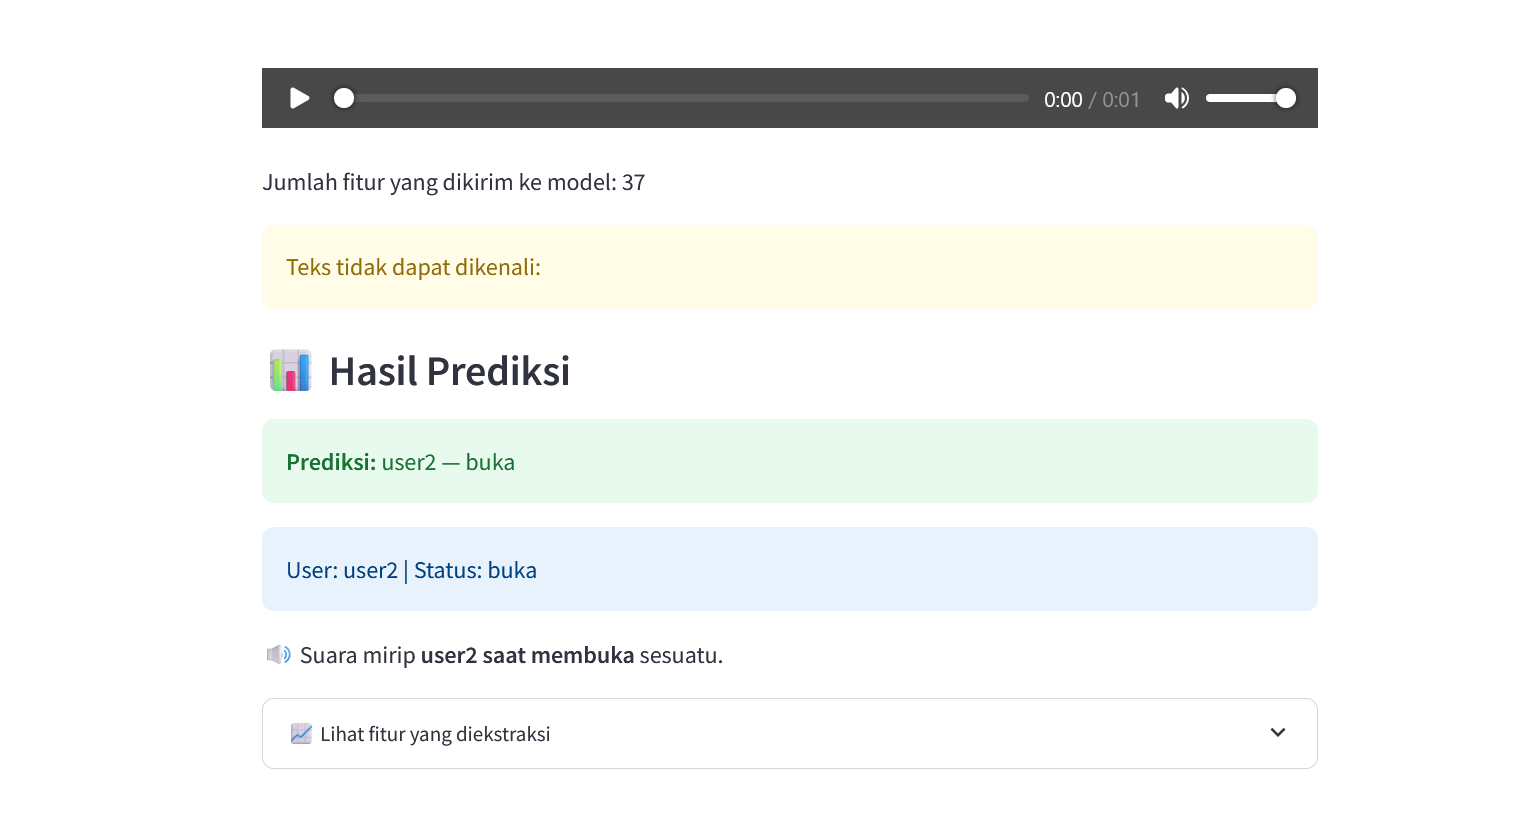